# Visualizing VSPO clipper data from Holodex



## Set up

- imports
- load Japanese font 
- `rcParams`
- `matplotlib` and `seaborn` settings

In [1]:
import pandas as pd 
import numpy as np 

from pathlib import Path 

import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns 

DATADIR = Path.cwd().parent / 'data/vspo_clippers'

In [2]:
import matplotlib.font_manager as fm

plt.style.use('default')
sns.set_style('whitegrid')

font_path = r"C:/Users/delbe/AppData/Local/Programs/Python/Python310/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/arial-unicode-ms.ttf"
fm.fontManager.addfont(font_path)
cjk_font = fm.FontProperties(fname=font_path, size=13)

sns.set(font=cjk_font.get_family())
sns.set_style('whitegrid', {"font.sans-serif":[cjk_font.get_name()]})

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = cjk_font.get_name()  

In [3]:
rcParams.update({
    'figure.dpi' : 300,
    'ytick.labelsize' : 8,
    'xtick.labelsize' : 9, 
    'figure.constrained_layout.use' : True,
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.2, 
    'axes.formatter.limits' : (-3, 3),
    'axes.grid' : False, 
    'axes.titlepad' : 14
})

### Convenience functions for plotting

In [4]:
from datetime import datetime

def style_ticklabels(ax: plt.Axes, axis: str, names: list[str], append='', **kwargs) -> None:
    if axis == 'x':
        labs = ax.xaxis.get_ticklabels()
    else:
        labs = ax.yaxis.get_ticklabels()
    
    for lab in labs:
        t = lab.get_text()
        if t in names:
            lab.set_text(t + append)
            lab.set(**kwargs)

    return 

def dt2mdy(dt: datetime) -> str:
    return datetime.strftime(dt, r"%b %d, %Y")

def get_title(dates: pd.Series) -> str:
    r = (dates.min(), dates.max())      # range 
    first, last = map(dt2mdy, r)
    ndays = (r[1] - r[0]).\
        total_seconds() // 86400
    
    return f"{first} ~ {last} ({ndays:.0f} days)"

def basic_barplot(
    x: list, y: list, 
    xlabel: str, ylabel: str, title: str, 
    xlab_kw: dict={},
    barplot_kw: dict=dict(palette='rocket'), 
    ylab_kw: dict=dict(rotation=0, loc='top', labelpad=-200),
    title_kw: dict = dict(x=-0.4, pad=22, fontsize=12, ha='left'),
    ) -> tuple[plt.Figure, plt.Axes]:
    
    fig, ax = plt.subplots(figsize=(4, 11))
    sns.barplot(x=x, y=y, ax=ax, **barplot_kw)

    ax.set_title(title, **title_kw)
    ax.set_xlabel(xlabel, **xlab_kw)
    ax.set_ylabel(ylabel, **ylab_kw)

    ax.tick_params(axis='y', labelsize=8)
    ax.xaxis.set_label_position('top')

    return fig, ax 


## Import data

- Import data
- Methods to access/index data 
- Methods to compute certain statistics

In [5]:
# functions for `pd.DataFrame.agg`
_quant25 = lambda x: np.quantile(x, 0.25)
_quant75 = lambda x: np.quantile(x, 0.75)

def get_agg_stats(df: pd.DataFrame, col: str=None, by: str=None) -> pd.DataFrame:
    new_cols = ['mean', 'median', '25pctl', '75pctl', 'min', 'max', 'std', 'sum', 'count']
    funcs = ['mean', np.median, _quant25, _quant75, 'min', 'max', np.std, 'sum', 'count']

    if isinstance(df, pd.Series) or df.shape[1] < 2:
        fs = funcs[:2] + funcs[4:]
        ns = new_cols[:2] + new_cols[4:]
        ns.extend(new_cols[2:4])

        _stats = df.agg(fs).tolist()
        _stats.extend(df.quantile([0.25, 0.75]))
        df_stats = pd.Series(_stats, index=ns)

    else:
        df_stats = df.groupby(by).agg(funcs)
        df_stats.columns = new_cols
    
    return df_stats.sort_values('count', ascending=False) 

def gby_fn(df: pd.DataFrame, by: str, fn: object) -> pd.DataFrame:
    return df.groupby(by).agg(fn)

def date_slice(df: pd.DataFrame, dt_col='Date', start: datetime=None, end: datetime=None) -> pd.DataFrame:
    dt = df.loc[:, dt_col]
    start = start if start else dt.min()
    end = end if end else dt.max()
    
    return df.loc[(dt < end) & (dt > start), :]

def sep_by_unit(df: pd.DataFrame, dt_col='Date', unit='month') -> dict[str, pd.DataFrame]:
    
    dt_props = df.loc[:, dt_col].dt
    if unit == 'month':
        units = dt_props.month_name()
    elif unit == 'year':
        units = dt_props.year 
    elif unit in ['week', 'weekofyear']:
        units = dt_props.isocalendar().week
    elif unit == 'dayofweek':
        units = dt_props.day_of_week
    elif unit == 'day':
        units = dt_props.day 
    elif unit == 'dayofyear':
        units = dt_props.day_of_year
    else:
        raise NotImplemented()

    uq = units.unique()
    return {u : df.loc[units == u, :] for u in uq}

def stats_by_unit(df: pd.DataFrame, dt_col='Date', unit='month', col=None, by=None) -> dict[str, pd.DataFrame]:
    return {
        dt_val : get_agg_stats(df_dt, col=col, by=by)
        for dt_val, df_dt in 
        sep_by_unit(df, dt_col=dt_col, unit=unit).items()
    }



In [6]:
data = pd.read_csv(DATADIR / 'merged.csv', index_col=0, header=0, encoding='utf-8', parse_dates=['Date'])
data.Channel = data.Channel.str.strip()
DT_PROPS = data['Date'].dt
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3458 entries, 599 to 1057
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3458 non-null   datetime64[ns]
 1   Duration  3458 non-null   int64         
 2   Channel   3458 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 108.1+ KB


In [7]:
total_stats = get_agg_stats(data, 'Duration', by='Channel')
monthly_stats_dict = stats_by_unit(data, by='Channel', col='Duration')


## Visualizations

1. For EN vs. JP clippers, count and duration: sum, boxplot
2. July - October: count, duration + cumulative sum, running average
   1. Total
   2. Stratified by EN vs JP clippers

### Convenience functions for plotting

In [8]:
import regex as re 

def secs2dhms(secs: int) -> str:
    units = [86400, 3600, 60]
    dhms = [] 
    
    for u in units:
        n = secs // u 
        secs -= u*n 
        dhms.append(n)

    return f"{dhms[0]} days, {dhms[1]} hours, {dhms[2]} minutes, {round(secs, 0)} seconds"

JAP_PAT = re.compile(r"[a-zA-Z]+")

def get_EN_JP_channels(df: pd.DataFrame, col='Channel') -> tuple[np.ndarray]:
    clippers = df[col].unique()
    clippers.sort()

    en_clippers = np.array(['Daruma English Clip', 'Ene Chan',
        'Galaxy VTuber Translations', 'Holo EYE',
        'Hololive are Idols [TL]', 'IonXepH', 'Laplus Clip / Hololive',
        'Leveret Translations', 'Nel', 'Oboretai Writing ch.',
        'Otaku-kun subs', 'Pebo-kun TL ぺぼ', 'R Subs', 'Renri',
        'Rezado-subs', 'Sakura [Vtuber切り抜き翻訳]', 'ShiroiRika',
        'Slice of Vspo', 'Sobbers Clipper', 'Towa Clips', 'TungT',
        'Ush Order Subs', 'V LOVE CLIP English', 
        'Virtualyzm', 'Vspo! Clips', 'Vspo!【Eng Clip】', 'Vtube Tengoku',
        'Vtuber resistance-Eng sub', 'What I Like Subs',
        'X-ray VSPO!【Eng Sub】', 'Yudha 【Ruuzami】', 'Yuri Shizu',
        'Yuri Shizu -Sub Channel-', 'Zoro Zaki [ Clypto ]', 'kanaway',
        'kuzuha blood pack', 'oyama clips', 'rinrinz', 'yd_',
    ])

    jp_clippers = clippers[~np.isin(clippers, en_clippers)]

    print(f"Number of channels:\nJP: {jp_clippers.size}, EN: {en_clippers.size}")
    return en_clippers, jp_clippers

def get_EN_JP_clips(df: pd.DataFrame, en_clippers: list[str], col='Channel') -> tuple[pd.DataFrame]:
    isEN = df[col].isin(en_clippers)
    en_clips = data.loc[isEN, :]
    jp_clips = data.loc[~isEN, :]
    return en_clips, jp_clips

def total_duration(clips: list[pd.DataFrame], col='Duration', as_hrs=True) -> list[float]:
    return list(
        map(
            lambda x: x/3600, 
            (df[col].sum() for df in clips)
        )
    )

func2dict = lambda d, func: {k : func(v) for k, v in d.items()}

def annotate_bars(ax: plt.Axes, xvals: list, yvals: list, labels=None, orient='v', fmt="%.0f", label_suffix: list=None, **kwargs) -> None:
    
    coords = [xvals, yvals]
    
    for i, vals in enumerate(coords):
        if not isinstance(vals[0], (float, int, np.int32, np.int64, np.float32, np.float64)):
            coords[i] = range(len(vals))
    
    if labels is None:
        labels = yvals if orient in ['v', 'vertical'] else xvals
    if label_suffix is None or isinstance(label_suffix, str):
        label_suffix = ['']*len(labels)
        
    for i, (x, y) in enumerate(zip(*coords)):
        ax.text(
            x, y, 
            (fmt % labels[i]) + f"{label_suffix[i]}", 
            transform=ax.transData,
            **kwargs
        )


In [9]:
TITLE = get_title(data['Date'])
def add_title(fig: plt.Figure, title=TITLE) -> None:
    fig.suptitle(TITLE, x=0, ha='left', fontweight='bold', fontsize=10, va='bottom', y=1.1)

In [10]:
langs = ['EN', 'JP']
clippers = {lang : df for lang, df in zip(langs, get_EN_JP_channels(data))}
clips = {lang : df for lang, df in zip(langs, get_EN_JP_clips(data, clippers['EN']))}

Number of channels:
JP: 70, EN: 39


### Stratified by channel language

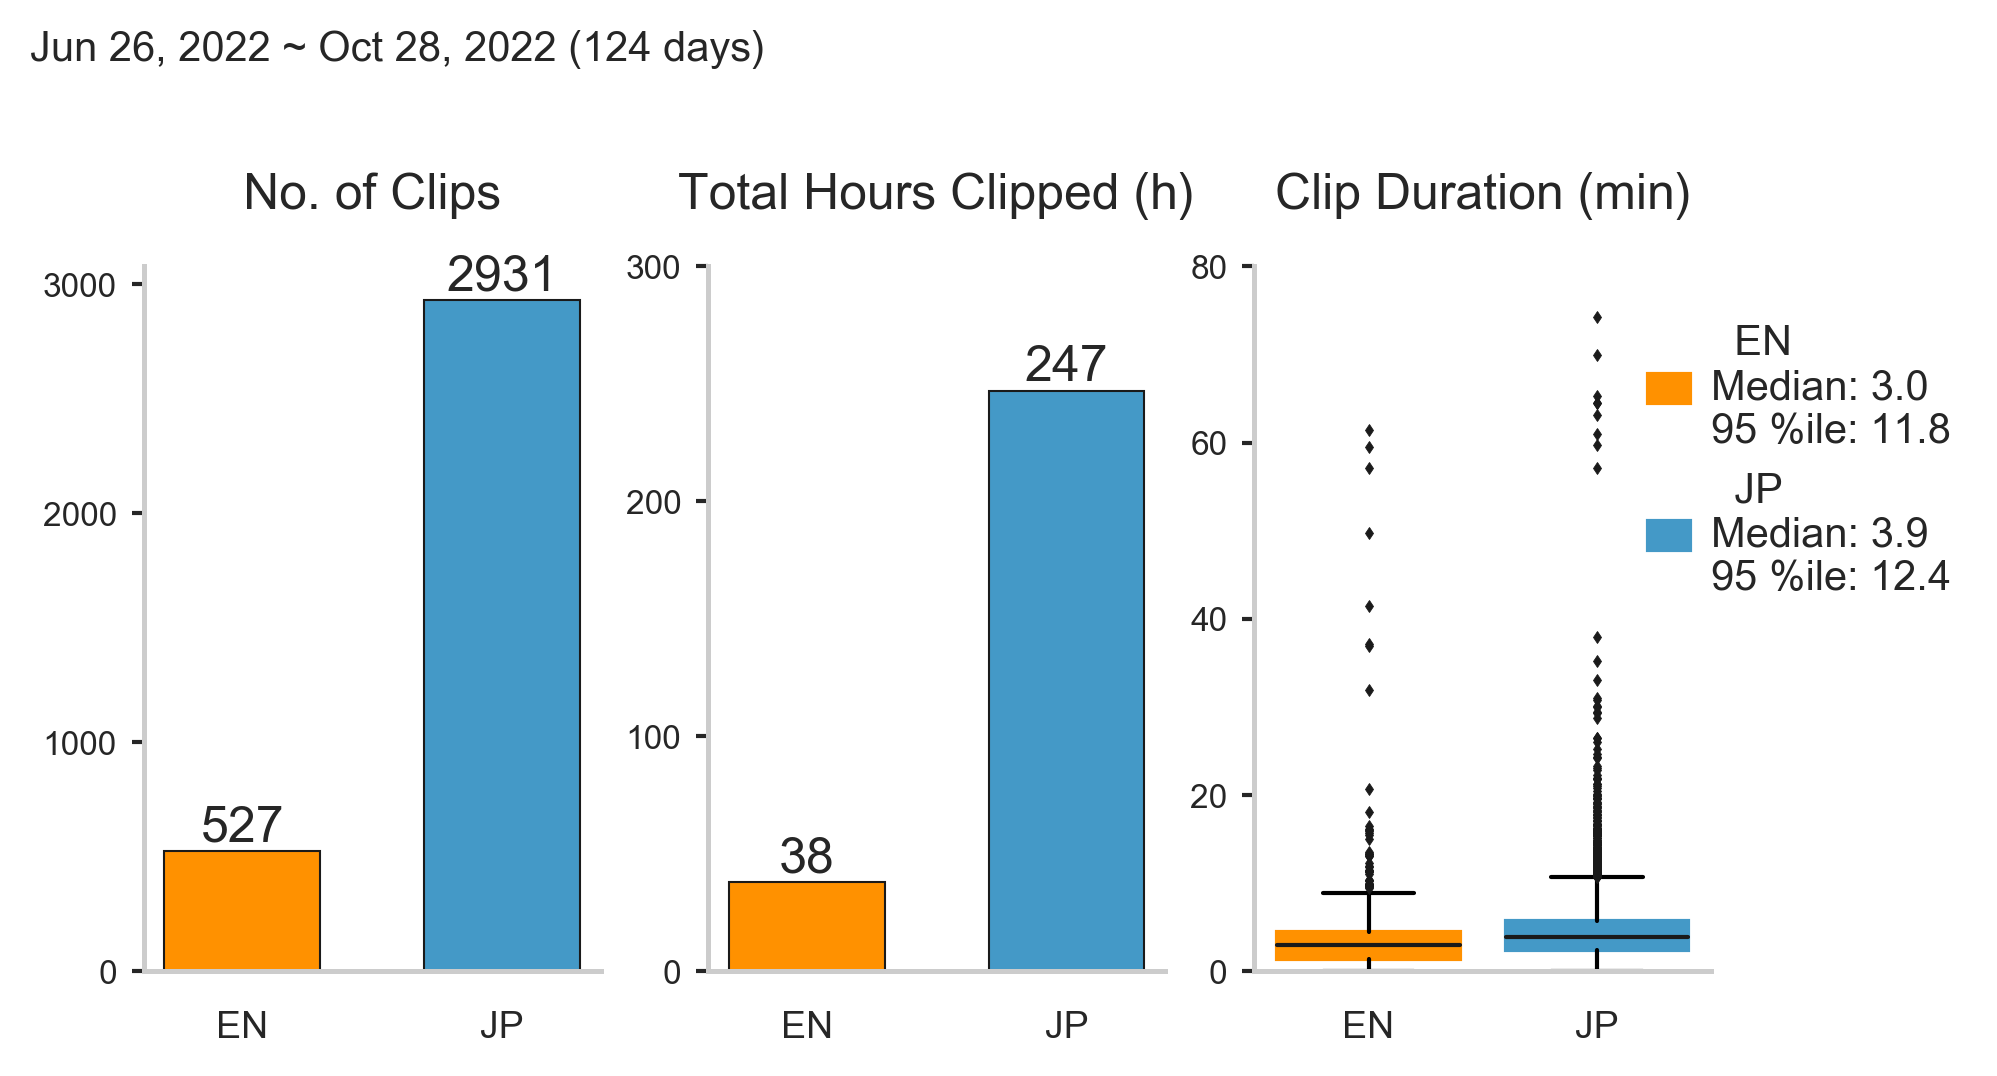

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(6.5,  3))

add_title(fig)
colors = ['#ff9100', '#4499c7']
kw = dict(
    width=0.6,
    color = colors,
    edgecolor = 'k',
    linewidth = 0.5
)

y = [v.shape[0] for v in clips.values()]
ax[0].bar(x=langs, height=y, **kw)
annotate_bars(ax[0], langs, y, ha='center', va='bottom')
ax[0].ticklabel_format(axis='y', scilimits=(2, 4))
ax[0].set_title("No. of Clips")

y = [v['Duration'].sum()/3600 for v in clips.values()]
ax[1].bar(x = langs, height = y, **kw)

annotate_bars(ax[1], langs, y, ha='center', label_suffix='h', va='bottom')
ax[1].set_title("Total Hours Clipped (h)")
ax[1].set_ylim((0, 300))

y = [v['Duration']/60 for v in clips.values()]
bp = ax[2].boxplot(
    y,
    sym='d',
    widths=0.8,
    labels=clips.keys(),
    flierprops=dict(mec='k', ls='none', mew=0.2, mfc='k', ms=2),
    medianprops=dict(color='k'),
    patch_artist=True,
)

ax[2].set_title('Clip Duration (min)')
ax[2].set_ylim((0, 80))
for box, clr in zip(bp['boxes'], colors):
    plt.setp(box, facecolor=clr, color=clr)

box_lab_fmt = lambda x, i: f"Median: {np.median(x[i]):.1f}\n95 %ile: {np.quantile(x[i], 0.95):.1f}"
box_labs = [f"  {lang}\n" + box_lab_fmt(y, i) for i, lang in enumerate(langs)]
ax[2].legend(
    bp['boxes'], box_labs, 
    loc='upper left', bbox_to_anchor=[0.78, 0.97], 
    fontsize=10, handlelength=1, handletextpad=0.5, frameon=False)

for a in ax:
    sns.despine(ax=a)
    a.locator_params(axis='y', nbins=5)
    a.tick_params(axis='y', length=3, width=1, left=True)

### Stratified by channel, but not time

Text(0.5, 0, 'No. of Clips')

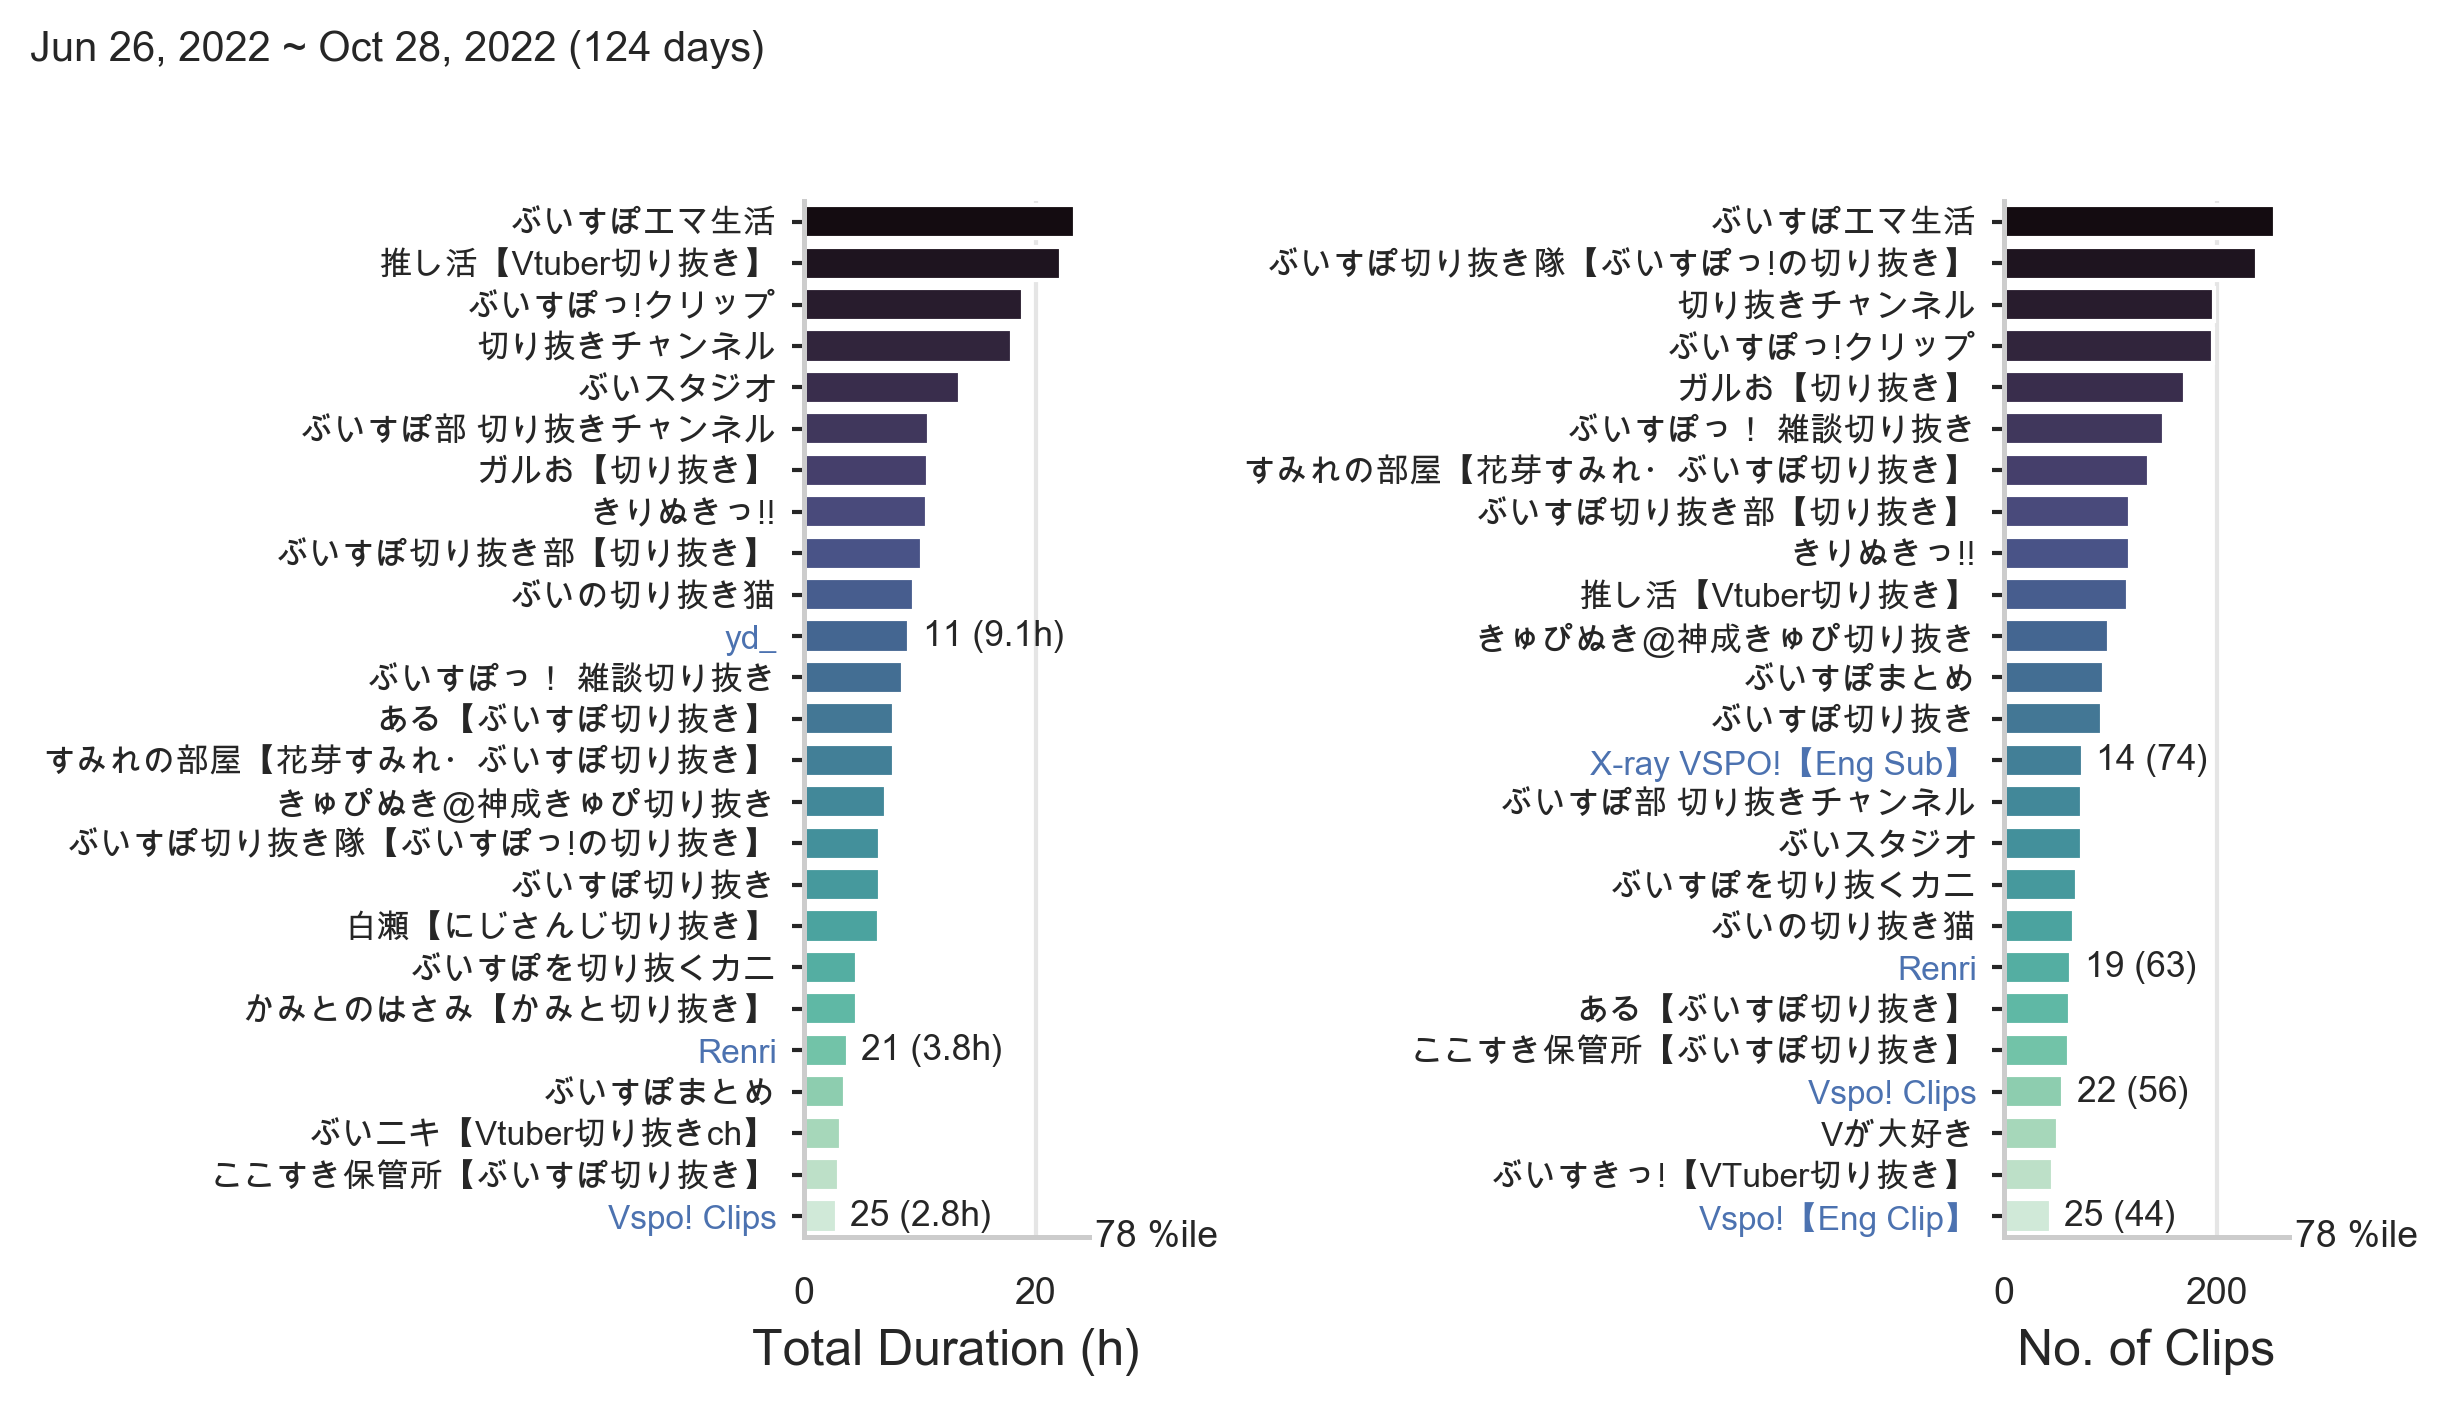

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

df_ch = data.loc[:, ['Channel', 'Duration']].groupby('Channel').\
    agg(['sum', 'count'])

df_ch.iloc[:,0] /= 3600

add_title(fig)

for i in range(2):
    df_i = df_ch.iloc[:,i].sort_values(ascending=False)
    
    y = df_i.iloc[:25]
    sns.barplot(x=y.values, y=y.index, palette='mako', ax=axs[i])
    # axs[i].boxplot(df_i, positions=[-1], vert=False, sym='d', showfliers=False, patch_artist=True, widths=(1,))

    # axs[i].set_ylabel('Channel', rotation=0, loc='top', labelpad=-100)
    axs[i].tick_params(axis='y', labelsize=8, length=3, width=1, left=True)
    sns.despine(ax=axs[i])

    style_ticklabels(axs[i], 'y', clippers['EN'], color='b', fontweight='bold',  append="\N{BLACK FOUR POINTED STAR}")
    axs[i].set_ylabel(None)

    inds = np.arange(25, dtype=int)
    inds = inds[np.isin(y.index, clippers['EN'])]
    y_en = y.iloc[inds]
    
    axs[i].grid(True, axis='x', alpha=0.5, lw=1)
    annotate_bars(
        axs[i], y_en + 0.05 * y.max(), 
        inds, 
        labels=inds+1,
        label_suffix=[
            f' ({v:.1f}h)' if isinstance(v, float) 
            else f' ({v:d})' for v in y_en
        ],
        orient='h', 
        ha='left', 
        va='center',
        fontsize=8.5,
        fontweight='semibold',
        zorder=2
    )

    _25pctile = np.mean(df_i.values <= df_i.iat[24]) * 100
    axs[i].text(1.02, 0, f"{_25pctile:.0f} %ile", ha='left', va='center', fontsize=9, transform=axs[i].transAxes)

axs[0].set_xlabel('Total Duration (h)')
axs[1].set_xlabel('No. of Clips')

### Stratify by time

In [31]:
df_monthly = data['Duration'].groupby([DT_PROPS.month, data['Channel'].\
    isin(clippers['EN'])]).\
    agg(['sum', 'count']).\
    rename({False : 'JP', True : 'EN'}, axis=0, level=1).\
    rename_axis(('Month', 'Language'), axis=0).\
    loc(axis=0)[range(7, 11), :]

df_monthly

sum  count
Month Language               
7     JP        201143    731
      EN         33898    131
8     JP        230171    790
      EN         29498    126
9     JP        228790    691
      EN         31451    136
10    JP        198837    594
      EN         38477    118

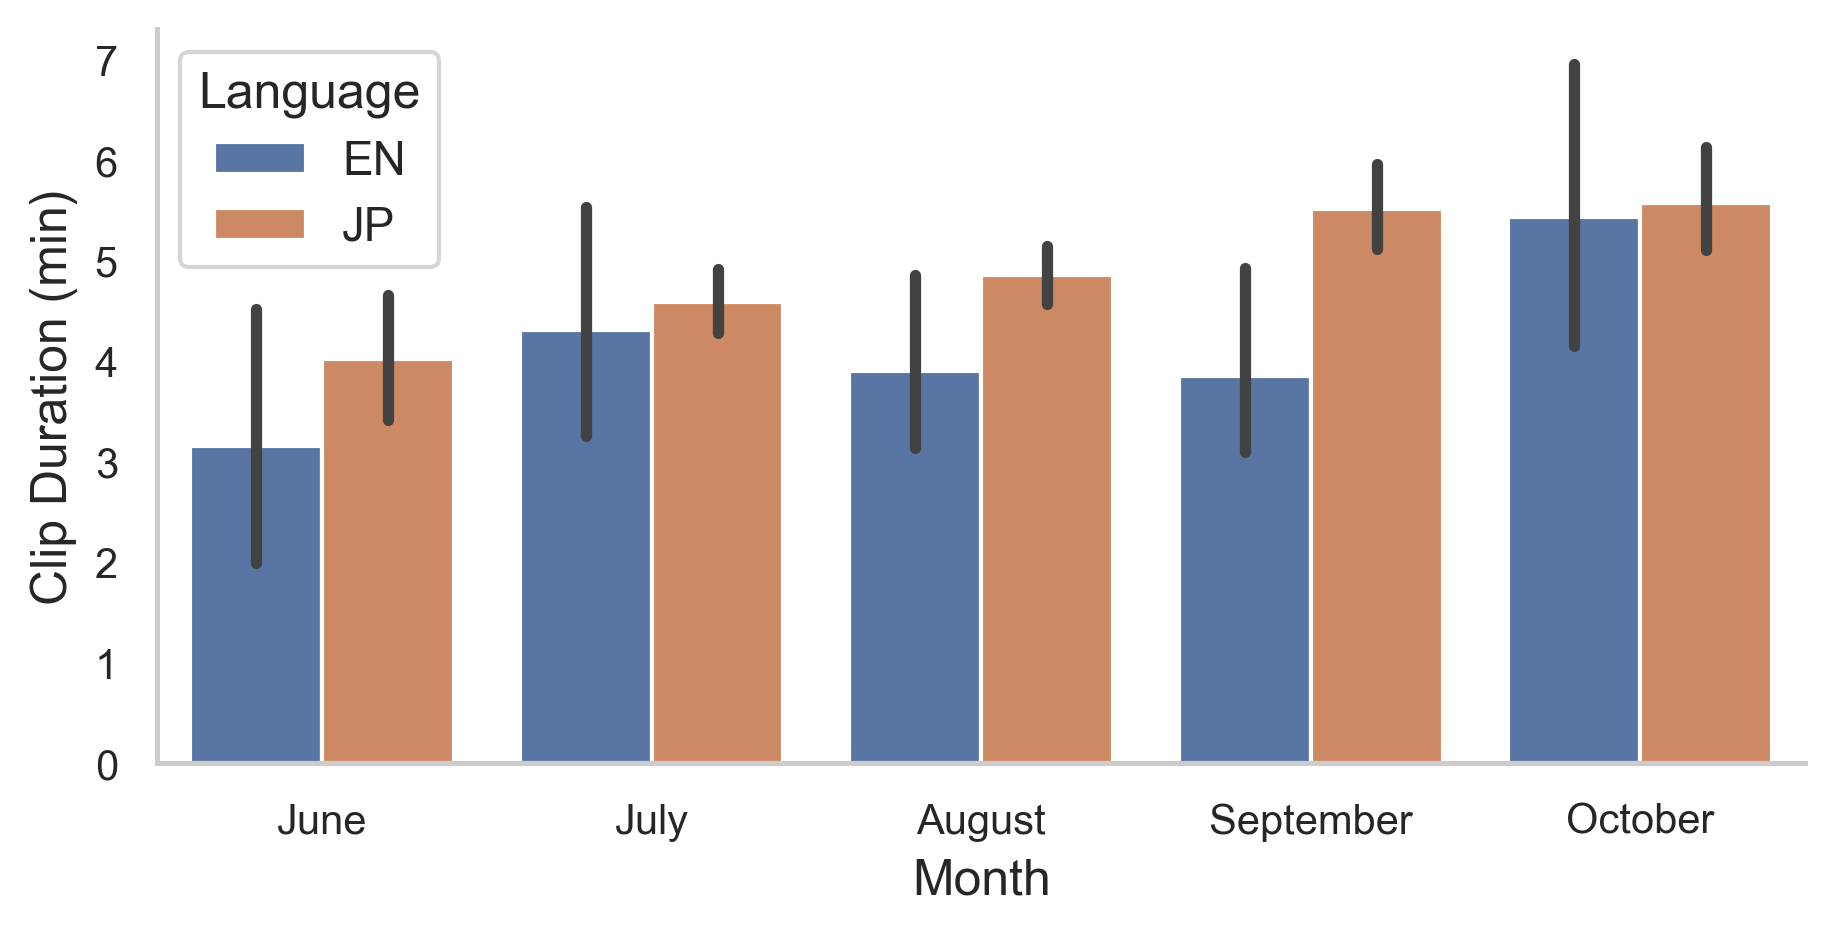

In [63]:
y_monthly = pd.concat(
    [
        data['Duration'] / 60,
        DT_PROPS.month_name(),
        data['Channel'].isin(clippers['EN'])
    ],
    axis=1
)

y_monthly.Channel.replace({False : 'JP', True : 'EN'}, inplace=True)
y_monthly.columns = ['Duration', 'Month', 'Language']

_, ax = plt.subplots(figsize=(6, 3))
ax = sns.barplot(data=y_monthly, x='Month', y='Duration', hue='Language', ax=ax)
ax.set_ylabel('Clip Duration (min)')
ax.tick_params(axis='both', labelsize=10)
sns.despine(ax=ax)



Text(0, 0.5, 'Median')

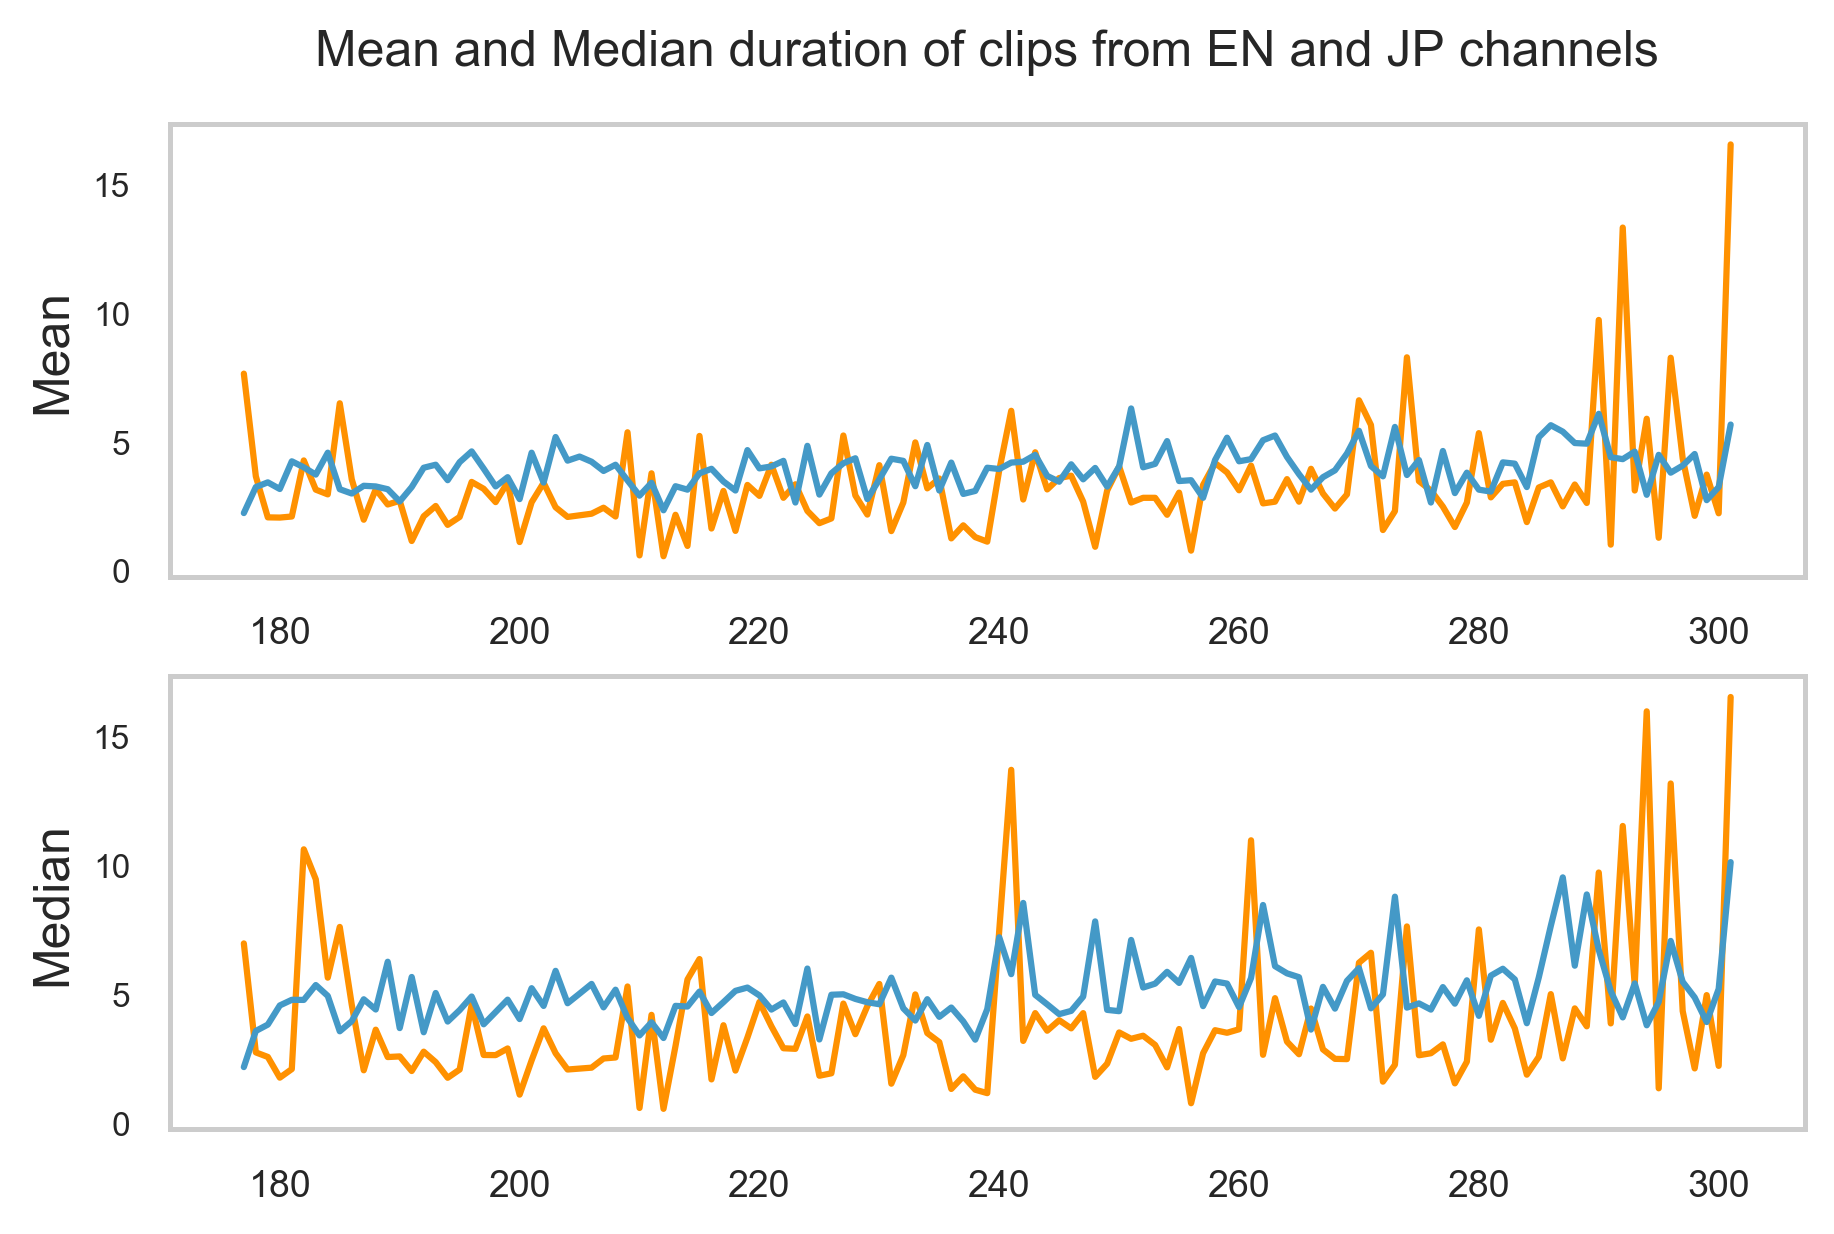

In [104]:
_, ax = plt.subplots(2, 1, figsize=(6, 4))

y_daily = pd.concat([
    data['Duration']/60,
    data['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).median().sort_index()

ax[0].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[0].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

y_daily = pd.concat([
    data['Duration']/60,
    data['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).mean().sort_index()

ax[1].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[1].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

ax[0].set_title('Mean and Median duration of clips from EN and JP channels')
ax[0].set_ylabel("Mean")
ax[1].set_ylabel("Median")

Some interesting observations,

- The JP and EN lines seem to track each other quite closely, but
- the JP line is consistently higher than the EN line 

Text(0, 0.5, 'Median')

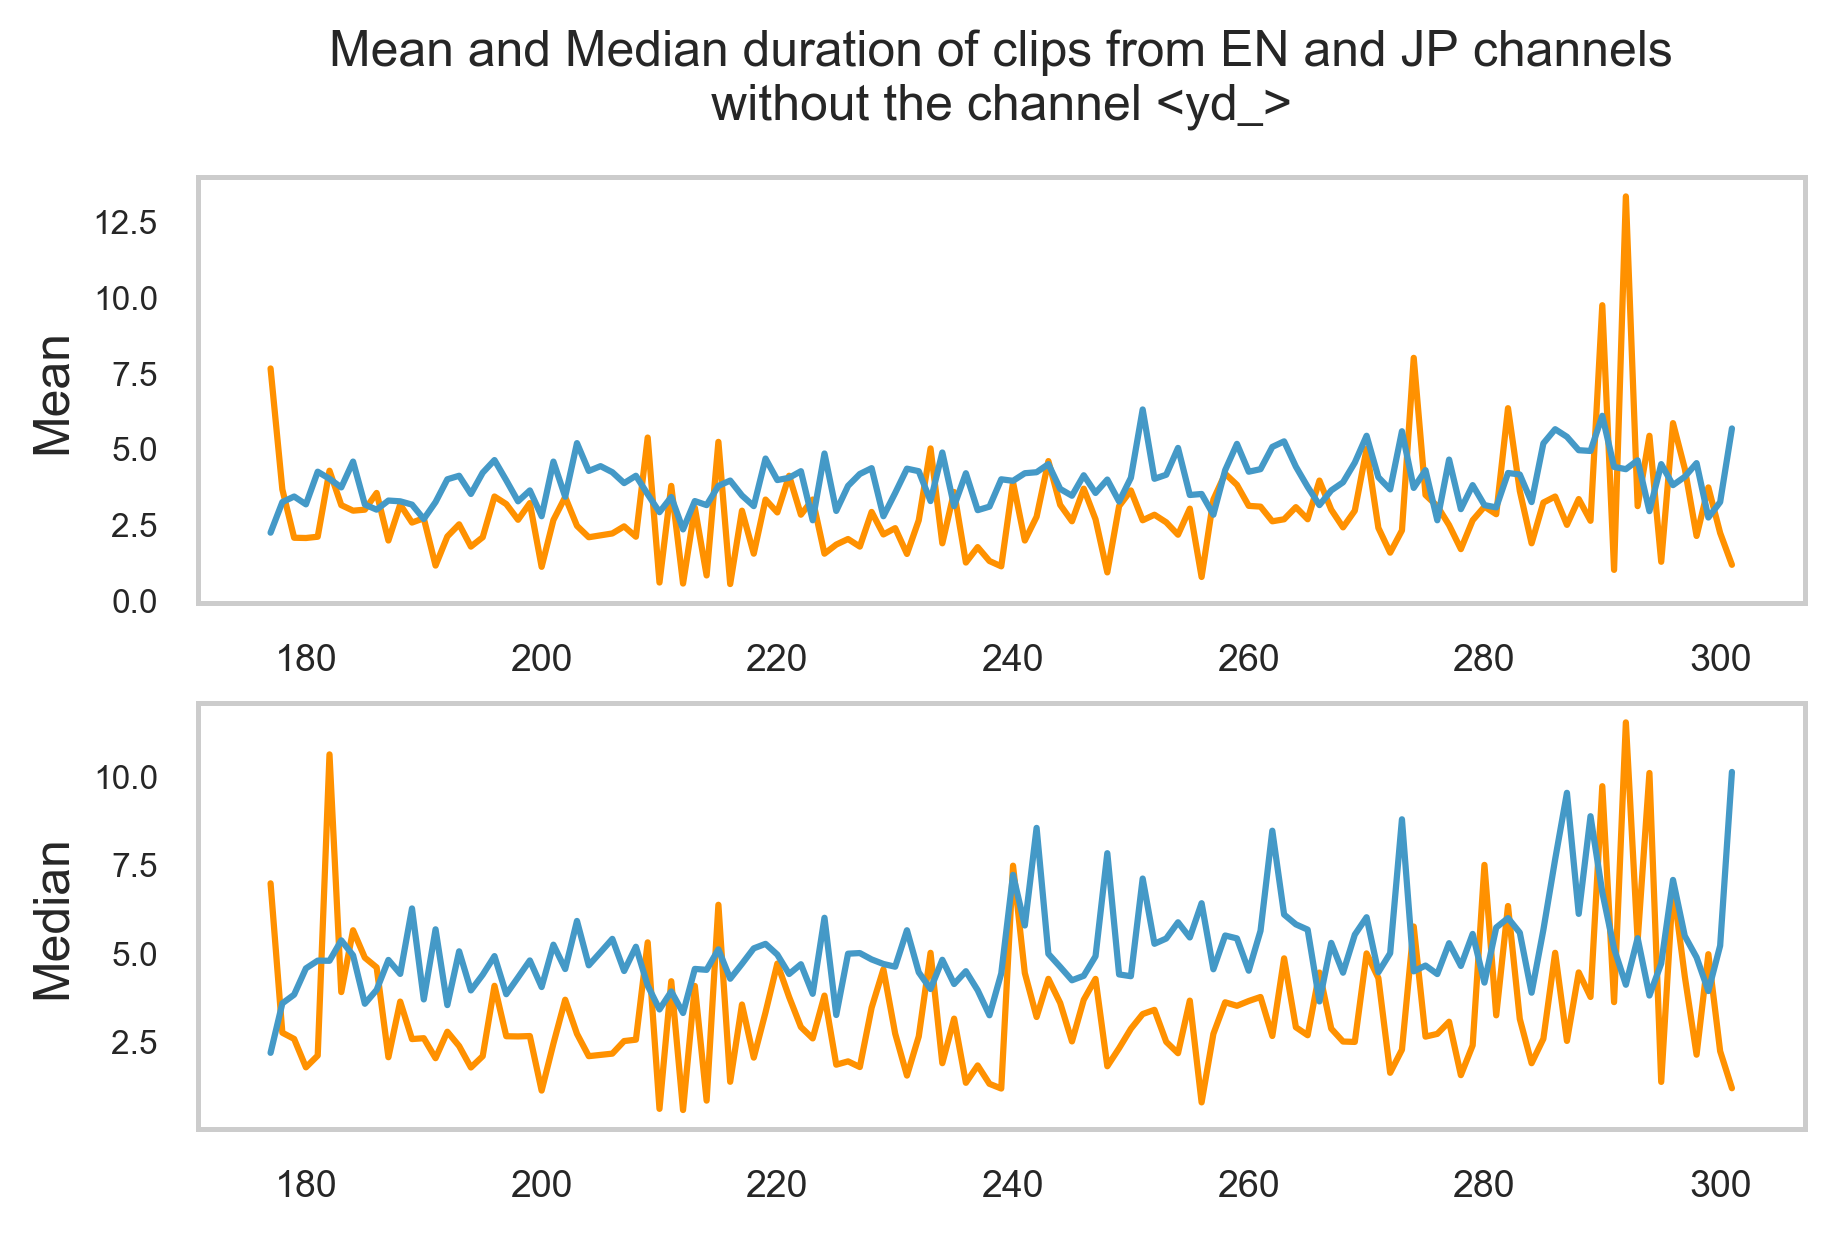

In [108]:
data_noMe = data.loc[data['Channel'] != 'yd_', :]
y_daily = pd.concat([
    data_noMe['Duration']/60,
    data_noMe['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).median().sort_index()

_, ax = plt.subplots(2, 1, figsize=(6, 4))

ax[0].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[0].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

y_daily = pd.concat([
    data_noMe['Duration']/60,
    data_noMe['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).mean().sort_index()

ax[1].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[1].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

ax[0].set_title('Mean and Median duration of clips from EN and JP channels\nwithout the channel <yd_>')
ax[0].set_ylabel("Mean")
ax[1].set_ylabel("Median")

<AxesSubplot:xlabel='Month', ylabel='sum'>

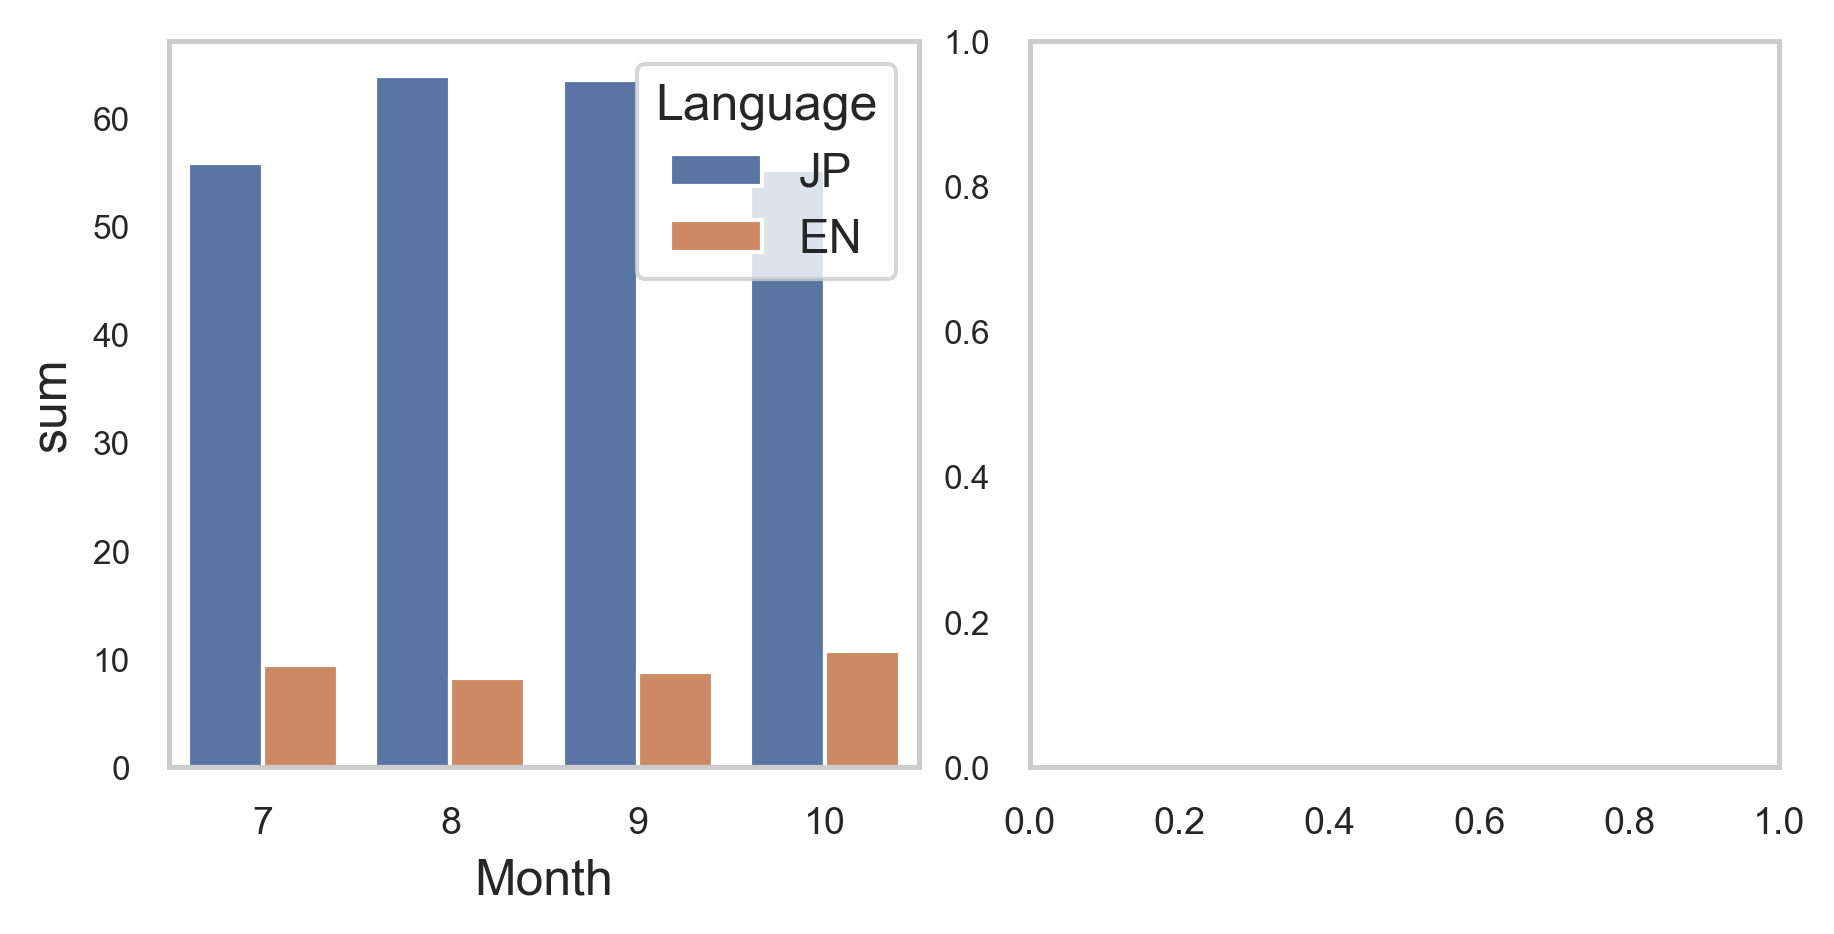

In [44]:
MONTH_NAMES = ['July', 'Aug', 'Sept', 'Oct']
y = df_monthly.reset_index()
y['sum'] /= 3600

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
sns.barplot(data=y, x=y.Month, y=y['sum'], hue='Language', ax=axs[0])